<a href="https://colab.research.google.com/github/alboard/kaggle/blob/main/recys/code/hybrid/example_recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning - Recommendation System example

###### Links: [MovieLens (GroupLens)](https://grouplens.org/datasets/movielens/latest/)  |  [Article (TowardsDataScience)](https://towardsdatascience.com/modern-recommendation-systems-with-neural-networks-3cc06a6ded2c)

https://github.com/mdipietro09/DataScience_ArtificialIntelligence_Utils/blob/master/machine_learning/example_recommendation.ipynb 

### 0 - Setup

###### Import pckgs

In [ ]:
import warnings
warnings.filterwarnings("ignore")

## for data
import pandas as pd
import numpy as np
import re
from datetime import datetime

## for plotting
import matplotlib.pyplot as plt
import seaborn as sns

## for machine learning
from sklearn import metrics, preprocessing

## for deep learning
from tensorflow.keras import models, layers, utils  #(2.6.0)

###### Import data

In [ ]:
# Products
dtf_products = pd.read_excel("data_movies.xlsx", sheet_name="products")

dtf_products = dtf_products[~dtf_products["genres"].isna()]
dtf_products["product"] = range(0,len(dtf_products))
dtf_products["name"] = dtf_products["title"].apply(lambda x: re.sub("[\(\[].*?[\)\]]", "", x).strip())
dtf_products["date"] = dtf_products["title"].apply(lambda x: int(x.split("(")[-1].replace(")","").strip()) 
                                                             if "(" in x else np.nan)

## add features
dtf_products["date"] = dtf_products["date"].fillna(9999)
dtf_products["old"] = dtf_products["date"].apply(lambda x: 1 if x < 2000 else 0)

dtf_products

,movieId,title,genres,product,name,date,old
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,Toy Story,1995.0,1
1,2,Jumanji (1995),Adventure|Children|Fantasy,1,Jumanji,1995.0,1
2,3,Grumpier Old Men (1995),Comedy|Romance,2,Grumpier Old Men,1995.0,1
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,3,Waiting to Exhale,1995.0,1
4,5,Father of the Bride Part II (1995),Comedy,4,Father of the Bride Part II,1995.0,1
...,...,...,...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,9736,Black Butler: Book of the Atlantic,2017.0,0
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,9737,No Game No Life: Zero,2017.0,0
9739,193585,Flint (2017),Drama,9738,Flint,2017.0,0
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,9739,Bungo Stray Dogs: Dead Apple,2018.0,0


In [ ]:
# Users
dtf_users = pd.read_excel("data_movies.xlsx", sheet_name="users").head(10000)

dtf_users["user"] = dtf_users["userId"].apply(lambda x: x-1)

dtf_users["timestamp"] = dtf_users["timestamp"].apply(lambda x: datetime.fromtimestamp(x))
dtf_users["daytime"] = dtf_users["timestamp"].apply(lambda x: 1 if 6<int(x.strftime("%H"))<20 else 0)
dtf_users["weekend"] = dtf_users["timestamp"].apply(lambda x: 1 if x.weekday() in [5,6] else 0)

dtf_users = dtf_users.merge(dtf_products[["movieId","product"]], how="left")
dtf_users = dtf_users.rename(columns={"rating":"y"})

dtf_users

,userId,movieId,y,timestamp,user,daytime,weekend,product
0,1,1,4.0,2000-07-30 20:45:03,0,0,1,0
1,1,3,4.0,2000-07-30 20:20:47,0,0,1,2
2,1,6,4.0,2000-07-30 20:37:04,0,0,1,5
3,1,47,5.0,2000-07-30 21:03:35,0,0,1,43
4,1,50,5.0,2000-07-30 20:48:51,0,0,1,46
...,...,...,...,...,...,...,...,...
9995,66,248,3.0,2005-04-11 05:41:32,65,0,0,212
9996,66,255,0.5,2005-04-11 05:07:20,65,0,0,219
9997,66,260,2.5,2004-08-29 04:45:50,65,0,1,224
9998,66,272,3.5,2005-04-11 05:31:59,65,0,0,234


In [ ]:
# select only useful columns
dtf_products = dtf_products[["product","name","old","genres"]].set_index("product")
dtf_products.head()

,name,old,genres
product,,,
0,Toy Story,1,Adventure|Animation|Children|Comedy|Fantasy
1,Jumanji,1,Adventure|Children|Fantasy
2,Grumpier Old Men,1,Comedy|Romance
3,Waiting to Exhale,1,Comedy|Drama|Romance
4,Father of the Bride Part II,1,Comedy


In [ ]:
# extract context
dtf_context = dtf_users[["user","product","daytime","weekend"]]
dtf_context.head()

,user,product,daytime,weekend
0,0,0,0,1
1,0,2,0,1
2,0,5,0,1
3,0,43,0,1
4,0,46,0,1


In [ ]:
dtf_users = dtf_users[["user","product","y"]]
dtf_users.head()

,user,product,y
0,0,0,4.0
1,0,2,4.0
2,0,5,4.0
3,0,43,5.0
4,0,46,5.0


### 1 - Data Analysis

###### Products

In [ ]:
tags = [i.split("|") for i in dtf_products["genres"].unique()]
columns = list(set([i for lst in tags for i in lst]))
columns.remove('(no genres listed)')
print(columns)

NameError: ignored

In [ ]:
for col in columns:
    dtf_products[col] = dtf_products["genres"].apply(lambda x: 1 if col in x else 0)
dtf_products.head()

In [ ]:
fig, ax = plt.subplots(figsize=(20,5))
sns.heatmap(dtf_products==0, vmin=0, vmax=1, cbar=False, ax=ax).set_title("Products x Features")
plt.show()

###### Users

In [ ]:
dtf_users.groupby("user").count()["product"].sort_values(ascending=False).plot(
    kind="bar", color="green", title="Y by user", figsize=(20,5)).grid(axis='y')

In [ ]:
dtf_users["y"].value_counts().sort_index().plot(kind="bar", color="green", title="Y disribution", 
                                                figsize=(20,5)).grid(axis='y')
plt.show()

In [ ]:
tmp = dtf_users.copy()
dtf_users = tmp.pivot_table(index="user", columns="product", values="y")
missing_cols = list(set(dtf_products.index) - set(dtf_users.columns))
for col in missing_cols:
    dtf_users[col] = np.nan
dtf_users = dtf_users[sorted(dtf_users.columns)]
dtf_users

In [ ]:
fig, ax = plt.subplots(figsize=(20,5))
sns.heatmap(dtf_users.isnull(), vmin=0, vmax=1, cbar=False, ax=ax).set_title("Users x Products")
plt.show()

###### Context

In [ ]:
dtf_context["weekend"].value_counts().plot(kind="barh", color="green", title="Weekend (count)", 
                                         figsize=(5,3)).grid(axis='x')
plt.show()

In [ ]:
dtf_context["daytime"].value_counts().plot(kind="barh", color="green", title="Daytime (count)", 
                                         figsize=(5,3)).grid(axis='x')
plt.show()

### 2 - Preprocessing

- Scaling
- Partitioning

###### Scaling

In [ ]:
dtf_users = pd.DataFrame(preprocessing.MinMaxScaler(feature_range=(0.5,1)).fit_transform(dtf_users.values), 
                         columns=dtf_users.columns, index=dtf_users.index)
dtf_users

product,0,1,2,3,4,5,6,7,8,9,...,9731,9732,9733,9734,9735,9736,9737,9738,9739,9740
user,,,,,,,,,,,,,,,,,,,,,
0,0.8,NaN,0.750,NaN,NaN,0.750,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,NaN,0.833333,NaN,NaN,NaN,0.875,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.666667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
63,0.8,NaN,0.625,NaN,NaN,0.875,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


###### Partitioning

In [ ]:
split = int(0.8*dtf_users.shape[1])
split

7792

In [ ]:
# Train
dtf_train = dtf_users.loc[:, :split-1]
print("non-null data:", dtf_train[dtf_train>0].count().sum())
dtf_train

non-null data: 9329


product,0,1,2,3,4,5,6,7,8,9,...,7782,7783,7784,7785,7786,7787,7788,7789,7790,7791
user,,,,,,,,,,,,,,,,,,,,,
0,0.8,NaN,0.750,NaN,NaN,0.750,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,NaN,0.833333,NaN,NaN,NaN,0.875,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.666667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
63,0.8,NaN,0.625,NaN,NaN,0.875,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Test
dtf_test = dtf_users.loc[:, split:]
print("non-null data:", dtf_test[dtf_test>0].count().sum())
dtf_test

non-null data: 671


product,7792,7793,7794,7795,7796,7797,7798,7799,7800,7801,...,9731,9732,9733,9734,9735,9736,9737,9738,9739,9740
user,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 3 - Baseline (Content-Based)

In [ ]:
# Select a user
i = 1
train = dtf_train.iloc[i].to_frame(name="y")
test = dtf_test.iloc[i].to_frame(name="y")

print("train:", len(train[~train["y"].isna()]), "| test:", len(test[~test["y"].isna()]))
test.head()

train: 21 | test: 8


,y
product,
7792,NaN
7793,NaN
7794,NaN
7795,NaN
7796,NaN


In [ ]:
# add all products in test but empty
tmp = test.copy()
tmp["y"] = np.nan
train = train.append(tmp)
train.tail()

,y
product,
9736,NaN
9737,NaN
9738,NaN
9739,NaN
9740,NaN


In [ ]:
# Model
usr = train[["y"]].fillna(0).values.T
prd = dtf_products.drop(["name","genres"],axis=1).values
print("Users", usr.shape, " x  Products", prd.shape)

Users (1, 9741)  x  Products (9741, 20)


In [ ]:
# Numpy
import numpy as np

## usr_ft(users,fatures) = usr(users,products) x prd(products,features)
usr_ft = np.dot(usr, prd)
## normalize
weights = usr_ft / usr_ft.sum()
## predicted rating(users,products) = weights(users,fatures) x prd.T(features,products)
pred = np.dot(weights, prd.T)

test = test.merge(pd.DataFrame(pred[0], columns=["yhat"]), how="left", left_index=True, right_index=True).reset_index()
test = test[~test["y"].isna()]
test

,product,y,yhat
271,8063,0.812500,0.364068
513,8305,1.000000,0.441084
584,8376,0.777778,0.077697
674,8466,0.800000,0.215465
717,8509,0.500000,0.477922
758,8550,0.875000,0.356925
889,8681,1.000000,0.327055
1036,8828,0.500000,0.033233


In [ ]:
# Tensorflow
#import tensorflow as tf

## usr_ft(users,fatures) = usr(users,products) x prd(products,features)
#usr_ft = tf.matmul(usr, prd)
## normalize
#weights = usr_ft / tf.reduce_sum(usr_ft, axis=1, keepdims=True)
## rating(users,products) = weights(users,fatures) x prd.T(features,products)
#pred = tf.matmul(weights, prd.T)

#test = test.merge(pd.DataFrame(pred[0], columns=["yhat"]), how="left", left_index=True, right_index=True).reset_index()
#test = test[~test["y"].isna()]
#test

In [ ]:
# Evaluate
def mean_reciprocal_rank(y_test, predicted):
    score = []
    for product in y_test:
        mrr = 1 / (list(predicted).index(product) + 1) if product in predicted else 0
        score.append(mrr)
    return np.mean(score)

In [ ]:
print("--- user", i, "---")

top = 5
y_test = test.sort_values("y", ascending=False)["product"].values[:top]
print("y_test:", y_test)

predicted = test.sort_values("yhat", ascending=False)["product"].values[:top]
print("predicted:", predicted)

true_positive = len(list(set(y_test) & set(predicted)))
print("true positive:", true_positive, "("+str(round(true_positive/top*100,1))+"%)")
print("accuracy:", str(round(metrics.accuracy_score(y_test,predicted)*100,1))+"%")
print("mrr:", round(mean_reciprocal_rank(y_test, predicted),2))

--- user 1 ---
y_test: [8305 8681 8550 8063 8466]
predicted: [8509 8305 8063 8550 8681]
true positive: 4 (80.0%)
accuracy: 0.0%
mrr: 0.26


In [ ]:
test.merge(
        dtf_products[["name","old","genres"]], left_on="product", right_index=True
    ).sort_values("yhat", ascending=False)

,product,y,yhat,name,old,genres
717,8509,0.500000,0.477922,The Drop,0,Crime|Drama|Thriller
513,8305,1.000000,0.441084,"Wolf of Wall Street, The",0,Comedy|Crime|Drama
271,8063,0.812500,0.364068,Django Unchained,0,Action|Drama|Western
758,8550,0.875000,0.356925,Ex Machina,0,Drama|Sci-Fi|Thriller
889,8681,1.000000,0.327055,Mad Max: Fury Road,0,Action|Adventure|Sci-Fi|Thriller
674,8466,0.800000,0.215465,Whiplash,0,Drama
584,8376,0.777778,0.077697,Interstellar,0,Sci-Fi|IMAX
1036,8828,0.500000,0.033233,The Jinx: The Life and Deaths of Robert Durst,0,Documentary


### 4 - Model Desing & Testing (Collaborative Filtering)

###### Data

In [ ]:
train = dtf_train.stack(dropna=True).reset_index().rename(columns={0:"y"})
train.head()

NameError: ignored

In [ ]:
test = dtf_test.stack(dropna=True).reset_index().rename(columns={0:"y"})
test.head()

NameError: ignored

###### Model Design

In [ ]:
embeddings_size = 50
usr, prd = dtf_users.shape[0], dtf_users.shape[1]

# Users (,1,embedding_size) and Reshape (,embedding_size)
xusers_in = layers.Input(name="xusers_in", shape=(1,))
xusers_emb = layers.Embedding(name="xusers_emb", input_dim=usr, output_dim=embeddings_size)(xusers_in)
xusers = layers.Reshape(name='xusers', target_shape=(embeddings_size,))(xusers_emb)

# Products (,1,embedding_size) and Reshape (,embedding_size)
xproducts_in = layers.Input(name="xproducts_in", shape=(1,))
xproducts_emb = layers.Embedding(name="xproducts_emb", input_dim=prd, output_dim=embeddings_size)(xproducts_in)
xproducts = layers.Reshape(name='xproducts', target_shape=(embeddings_size,))(xproducts_emb)

# Product (,1) values[-1,1]
xx = layers.Dot(name='xx', normalize=True, axes=1)([xusers, xproducts])

# Predict ratings (,1)
y_out = layers.Dense(name="y_out", units=1, activation='linear')(xx)

# Compile
model = models.Model(inputs=[xusers_in,xproducts_in], outputs=y_out, name="CollaborativeFiltering")
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mean_absolute_percentage_error'])
model.summary()

NameError: ignored

In [ ]:
utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

###### Train / Test

In [ ]:
'''
Plot loss and metrics of keras training.
'''
def utils_plot_keras_training(training):
    metrics = [k for k in training.history.keys() if ("loss" not in k) and ("val" not in k)]
    fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(15,3))
    
    ## training
    ax[0].set(title="Training")
    ax11 = ax[0].twinx()
    ax[0].plot(training.history['loss'], color='black')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss', color='black')
    for metric in metrics:
        ax11.plot(training.history[metric], label=metric)
    ax11.set_ylabel("Score", color='steelblue')
    ax11.legend()
    
    ## validation
    ax[1].set(title="Validation")
    ax22 = ax[1].twinx()
    ax[1].plot(training.history['val_loss'], color='black')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Loss', color='black')
    for metric in metrics:
        ax22.plot(training.history['val_'+metric], label=metric)
    ax22.set_ylabel("Score", color="steelblue")
    plt.show()

In [ ]:
# train
training = model.fit(x=[train["user"], train["product"]], y=train["y"], 
                     epochs=100, batch_size=128, shuffle=True, verbose=0, validation_split=0.3)
model = training.model
utils_plot_keras_training(training)

In [ ]:
# test
test["yhat"] = model.predict([test["user"], test["product"]])
test

###### Evaluate

In [ ]:
# overall
y_test = test["y"]
predicted = test["yhat"]

print("Mean Absolute Error (Σ|y-pred|/n):", "{:,.0f}".format(metrics.mean_absolute_error(y_test, predicted)))
print("Mean Absolute Perc Error (Σ(|y-pred|/y)/n):", str(round(np.mean(np.abs((y_test-predicted)/predicted)), 2))+"%")

In [ ]:
# single case
i = 1
print("--- user", i, "---")

top = 5
y_test = test[test["user"]==i].sort_values("y", ascending=False)["product"].values[:top]
print("y_test:", y_test)

predicted = test[test["user"]==i].sort_values("yhat", ascending=False)["product"].values[:top]
print("predicted:", predicted)

true_positive = len(list(set(y_test) & set(predicted)))
print("true positive:", true_positive, "("+str(round(true_positive/top*100,1))+"%)")
print("accuracy:", str(round(metrics.accuracy_score(y_test,predicted)*100,1))+"%")
print("mrr:", round(mean_reciprocal_rank(y_test, predicted),2))

In [ ]:
test[test["user"]==i].merge(
        dtf_products[["name","old","genres"]], left_on="product", right_index=True
    ).sort_values("yhat", ascending=False)

### 5 - Model Desing & Testing (Neural Collaborative Filtering)

###### Data

In [ ]:
train = dtf_train.stack(dropna=True).reset_index().rename(columns={0:"y"})
train.head()

,user,product,y
0,0,0,0.80
1,0,2,0.75
2,0,5,0.75
3,0,43,1.00
4,0,46,1.00


In [ ]:
test = dtf_test.stack(dropna=True).reset_index().rename(columns={0:"y"})
test.head()

,user,product,y
0,1,8063,0.812500
1,1,8305,1.000000
2,1,8376,0.777778
3,1,8466,0.800000
4,1,8509,0.500000


###### Model Design

In [ ]:
embeddings_size = 50
usr, prd = dtf_users.shape[0], dtf_users.shape[1]

# Input layer
xusers_in = layers.Input(name="xusers_in", shape=(1,))
xproducts_in = layers.Input(name="xproducts_in", shape=(1,))

# A) Matrix Factorization
## embeddings and reshape
cf_xusers_emb = layers.Embedding(name="cf_xusers_emb", input_dim=usr, output_dim=embeddings_size)(xusers_in)
cf_xusers = layers.Reshape(name='cf_xusers', target_shape=(embeddings_size,))(cf_xusers_emb)
## embeddings and reshape
cf_xproducts_emb = layers.Embedding(name="cf_xproducts_emb", input_dim=prd, output_dim=embeddings_size)(xproducts_in)
cf_xproducts = layers.Reshape(name='cf_xproducts', target_shape=(embeddings_size,))(cf_xproducts_emb)
## product
cf_xx = layers.Dot(name='cf_xx', normalize=True, axes=1)([cf_xusers, cf_xproducts])

# B) Neural Network
## embeddings and reshape
nn_xusers_emb = layers.Embedding(name="nn_xusers_emb", input_dim=usr, output_dim=embeddings_size)(xusers_in)
nn_xusers = layers.Reshape(name='nn_xusers', target_shape=(embeddings_size,))(nn_xusers_emb)
## embeddings and reshape
nn_xproducts_emb = layers.Embedding(name="nn_xproducts_emb", input_dim=prd, output_dim=embeddings_size)(xproducts_in)
nn_xproducts = layers.Reshape(name='nn_xproducts', target_shape=(embeddings_size,))(nn_xproducts_emb)
## concat and dense
nn_xx = layers.Concatenate()([nn_xusers, nn_xproducts])
nn_xx = layers.Dense(name="nn_xx", units=int(embeddings_size/2), activation='relu')(nn_xx)

# Merge A & B
y_out = layers.Concatenate()([cf_xx, nn_xx])
y_out = layers.Dense(name="y_out", units=1, activation='linear')(y_out)

# Compile
model = models.Model(inputs=[xusers_in,xproducts_in], outputs=y_out, name="Neural_CollaborativeFiltering")
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mean_absolute_percentage_error'])
model.summary()

Model: "Neural_CollaborativeFiltering"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
xusers_in (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
xproducts_in (InputLayer)       [(None, 1)]          0                                            
__________________________________________________________________________________________________
nn_xusers_emb (Embedding)       (None, 1, 50)        3300        xusers_in[0][0]                  
__________________________________________________________________________________________________
nn_xproducts_emb (Embedding)    (None, 1, 50)        487050      xproducts_in[0][0]               
______________________________________________________________________

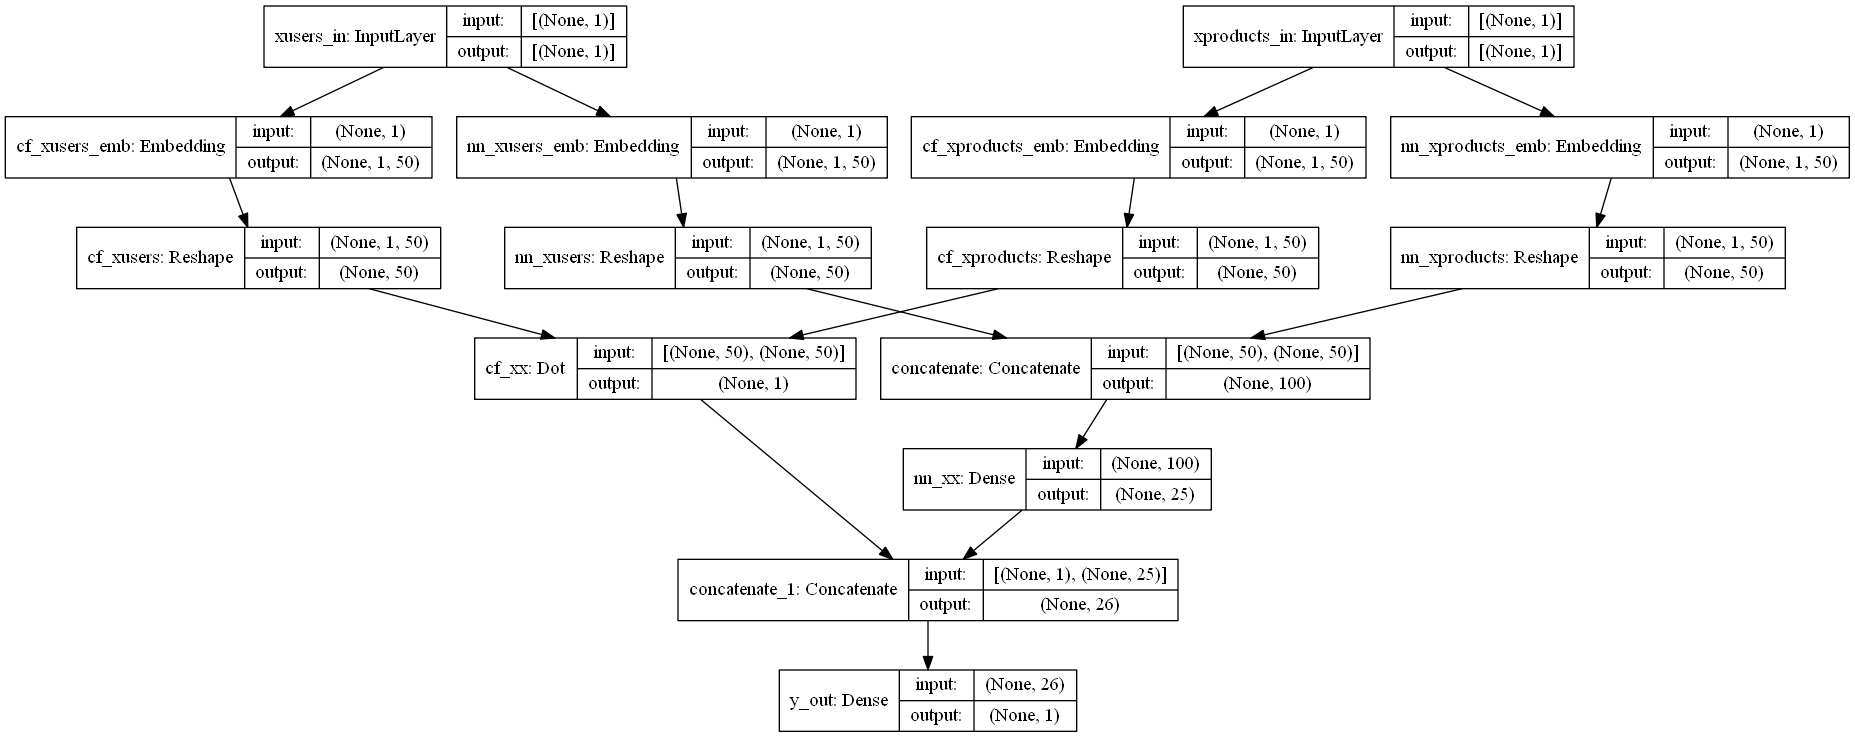

In [ ]:
utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

###### Train / Test

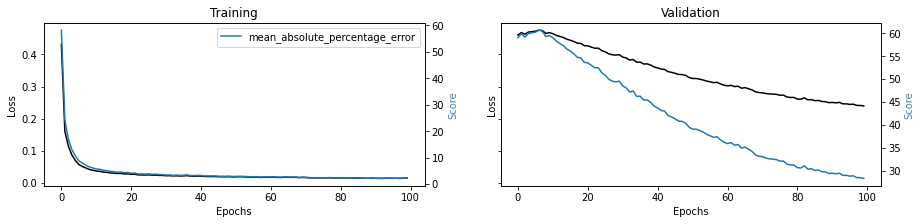

In [ ]:
# train
training = model.fit(x=[train["user"], train["product"]], y=train["y"], 
                     epochs=100, batch_size=128, shuffle=True, verbose=0, validation_split=0.3)
model = training.model
utils_plot_keras_training(training)

In [ ]:
# test
test["yhat"] = model.predict([test["user"], test["product"]])
test

,user,product,y,yhat
0,1,8063,0.812500,0.694346
1,1,8305,1.000000,0.717424
2,1,8376,0.777778,0.665485
3,1,8466,0.800000,0.725228
4,1,8509,0.500000,0.715174
...,...,...,...,...
666,64,8023,0.500000,0.640784
667,64,8376,0.944444,0.476182
668,64,8438,0.666667,0.570333
669,64,8569,0.900000,0.558572


###### Evaluate

In [ ]:
# overall
y_test = test["y"]
predicted = test["yhat"]

print("Mean Absolute Error (Σ|y-pred|/n):", "{:,.0f}".format(metrics.mean_absolute_error(y_test, predicted)))
print("Mean Absolute Perc Error (Σ(|y-pred|/y)/n):", str(round(np.mean(np.abs((y_test-predicted)/predicted)), 2))+"%")

Mean Absolute Error (Σ|y-pred|/n): 0
Mean Absolute Perc Error (Σ(|y-pred|/y)/n): 0.3%


In [ ]:
# single case
i = 1
print("--- user", i, "---")

top = 5
y_test = test[test["user"]==i].sort_values("y", ascending=False)["product"].values[:top]
print("y_test:", y_test)

predicted = test[test["user"]==i].sort_values("yhat", ascending=False)["product"].values[:top]
print("predicted:", predicted)

true_positive = len(list(set(y_test) & set(predicted)))
print("true positive:", true_positive, "("+str(round(true_positive/top*100,1))+"%)")
print("accuracy:", str(round(metrics.accuracy_score(y_test,predicted)*100,1))+"%")
print("mrr:", round(mean_reciprocal_rank(y_test, predicted),2))

--- user 1 ---
y_test: [8305 8681 8550 8063 8466]
predicted: [8828 8681 8550 8466 8305]
true positive: 4 (80.0%)
accuracy: 40.0%
mrr: 0.26


In [ ]:
test[test["user"]==i].merge(
        dtf_products[["name","old","genres"]], left_on="product", right_index=True
    ).sort_values("yhat", ascending=False)

,user,product,y,yhat,name,old,genres
7,1,8828,0.500000,0.852103,The Jinx: The Life and Deaths of Robert Durst,0,Documentary
6,1,8681,1.000000,0.792930,Mad Max: Fury Road,0,Action|Adventure|Sci-Fi|Thriller
5,1,8550,0.875000,0.728708,Ex Machina,0,Drama|Sci-Fi|Thriller
3,1,8466,0.800000,0.725228,Whiplash,0,Drama
1,1,8305,1.000000,0.717424,"Wolf of Wall Street, The",0,Comedy|Crime|Drama
4,1,8509,0.500000,0.715174,The Drop,0,Crime|Drama|Thriller
0,1,8063,0.812500,0.694346,Django Unchained,0,Action|Drama|Western
2,1,8376,0.777778,0.665485,Interstellar,0,Sci-Fi|IMAX


### 6 - Hybrid Model

###### Data

In [1]:
# Extra data
features = dtf_products.drop(["genres","name"], axis=1).columns
print(features)

context = dtf_context.drop(["user","product"], axis=1).columns
print(context)

NameError: ignored

In [ ]:
train = dtf_train.stack(dropna=True).reset_index().rename(columns={0:"y"})

## add features
train = train.merge(dtf_products[features], how="left", left_on="product", right_index=True)

## add context
train = train.merge(dtf_context, how="left")

train.head()

In [ ]:
test = dtf_test.stack(dropna=True).reset_index().rename(columns={0:"y"})

## add features
test = test.merge(dtf_products.drop(["genres","name"], axis=1), how="left", left_on="product", right_index=True)

## add context
test[context] = 0 #--> simulate production for a weekday night
#test = test.merge(dtf_context, how="left") #--> use test set

test.head()

###### Model Design

In [ ]:
embeddings_size = 50
usr, prd = dtf_users.shape[0], dtf_users.shape[1]
feat = len(features)
ctx = len(context)

########################################## COLLABORATIVE FILTERING ###################################################
# Input layer
xusers_in = layers.Input(name="xusers_in", shape=(1,))
xproducts_in = layers.Input(name="xproducts_in", shape=(1,))

# A) Matrix Factorization
## embeddings and reshape
cf_xusers_emb = layers.Embedding(name="cf_xusers_emb", input_dim=usr, output_dim=embeddings_size)(xusers_in)
cf_xusers = layers.Reshape(name='cf_xusers', target_shape=(embeddings_size,))(cf_xusers_emb)
## embeddings and reshape
cf_xproducts_emb = layers.Embedding(name="cf_xproducts_emb", input_dim=prd, output_dim=embeddings_size)(xproducts_in)
cf_xproducts = layers.Reshape(name='cf_xproducts', target_shape=(embeddings_size,))(cf_xproducts_emb)
## product
cf_xx = layers.Dot(name='cf_xx', normalize=True, axes=1)([cf_xusers, cf_xproducts])

# B) Neural Network
## embeddings and reshape
nn_xusers_emb = layers.Embedding(name="nn_xusers_emb", input_dim=usr, output_dim=embeddings_size)(xusers_in)
nn_xusers = layers.Reshape(name='nn_xusers', target_shape=(embeddings_size,))(nn_xusers_emb)
## embeddings and reshape
nn_xproducts_emb = layers.Embedding(name="nn_xproducts_emb", input_dim=prd, output_dim=embeddings_size)(xproducts_in)
nn_xproducts = layers.Reshape(name='nn_xproducts', target_shape=(embeddings_size,))(nn_xproducts_emb)
## concat and dense
nn_xx = layers.Concatenate()([nn_xusers, nn_xproducts])
nn_xx = layers.Dense(name="nn_xx", units=int(embeddings_size/2), activation='relu')(nn_xx)

########################################## CONTENT BASED ###################################################
# Product Features
features_in = layers.Input(name="features_in", shape=(feat,))
features_x = layers.Dense(name="features_x", units=feat, activation='relu')(features_in)

########################################## KNOWLEDGE BASED #################################################
# Context
contexts_in = layers.Input(name="contexts_in", shape=(ctx,))
context_x = layers.Dense(name="context_x", units=ctx, activation='relu')(contexts_in)

########################################## OUTPUT ###################################################
# Merge all
y_out = layers.Concatenate()([cf_xx, nn_xx, features_x, context_x])
y_out = layers.Dense(name="y_out", units=1, activation='linear')(y_out)

# Compile
model = models.Model(inputs=[xusers_in,xproducts_in, features_in, contexts_in], outputs=y_out, name="Hybrid_Model")
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mean_absolute_percentage_error'])
model.summary()

In [ ]:
utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

###### Train / Test

In [ ]:
# train
training = model.fit(x=[train["user"], train["product"], train[features], train[context]], y=train["y"], 
                     epochs=100, batch_size=128, shuffle=True, verbose=0, validation_split=0.3)

In [ ]:
model = training.model
utils_plot_keras_training(training)

In [ ]:
# test
test["yhat"] = model.predict([test["user"], test["product"], test[features], test[context]])
test

In [ ]:
# overall
y_test = test["y"]
predicted = test["yhat"]

print("Mean Absolute Error (Σ|y-pred|/n):", "{:,.0f}".format(metrics.mean_absolute_error(y_test, predicted)))
print("Mean Absolute Perc Error (Σ(|y-pred|/y)/n):", str(round(np.mean(np.abs((y_test-predicted)/predicted)), 2))+"%")

In [ ]:
# single case
i = 1
print("--- user", i, "---")

top = 5
y_test = test[test["user"]==i].sort_values("y", ascending=False)["product"].values[:top]
print("y_test:", y_test)

predicted = test[test["user"]==i].sort_values("yhat", ascending=False)["product"].values[:top]
print("predicted:", predicted)

true_positive = len(list(set(y_test) & set(predicted)))
print("true positive:", true_positive, "("+str(round(true_positive/top*100,1))+"%)")
print("accuracy:", str(round(metrics.accuracy_score(y_test,predicted)*100,1))+"%")
print("mrr:", round(mean_reciprocal_rank(y_test, predicted),2))